# Install Dependecies to Render OpenAI Gym Environment

In [1]:
# Run this asap since it takes 30 seconds.

import gymnasium as gym
#import gym
#from gym.wrappers import Monitor
#from gym.wrappers.record_video import RecordVideo
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import math
import time
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

# Build DQN Agent and Helper Functions

In [2]:
# Load gym environment and get action and state spaces.
env = gym.make('LunarLander-v2')
num_features = env.observation_space.shape[0]
num_actions = env.action_space.n
print('Number of state features: {}'.format(num_features))
print('Number of possible actions: {}'.format(num_actions))

Number of state features: 8
Number of possible actions: 4


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
class DQN(nn.Module):
    """Dense neural network class."""
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 32)
        self.fc2 = nn.Linear(32, 32)
        self.out = nn.Linear(32, num_actions)

    def forward(self, states):
        """Forward pass."""
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        return self.out(x)

main_nn = DQN(num_features, num_actions).to(device)
target_nn = DQN(num_features, num_actions).to(device)

optimizer = torch.optim.Adam(main_nn.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [5]:
class ReplayBuffer(object):
  """Experience replay buffer that samples uniformly."""
  def __init__(self, size, device="cpu"):
    """Initializes the buffer."""
    self.buffer = deque(maxlen=size)
    self.device = device

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def __len__(self):
    return len(self.buffer)

  def sample(self, num_samples):
    states, actions, rewards, next_states, dones = [], [], [], [], []
    idx = np.random.choice(len(self.buffer), num_samples)
    for i in idx:
      elem = self.buffer[i]
      state, action, reward, next_state, done = elem
      states.append(np.array(state, copy=False))
      actions.append(np.array(action, copy=False))
      rewards.append(reward)
      next_states.append(np.array(next_state, copy=False))
      dones.append(done)
    states = torch.as_tensor(np.array(states), device=self.device)
    actions = torch.as_tensor(np.array(actions), device=self.device)
    rewards = torch.as_tensor(
        np.array(rewards, dtype=np.float32), device=self.device
    )
    next_states = torch.as_tensor(np.array(next_states), device=self.device)
    dones = torch.as_tensor(np.array(dones, dtype=np.float32), device=self.device)
    return states, actions, rewards, next_states, dones

In [6]:
def select_epsilon_greedy_action(state, epsilon):
  """Take random action with probability epsilon, else take best action."""
  result = np.random.uniform()
  if result < epsilon:
    return env.action_space.sample() # Random action (left or right).
  else:
    qs = main_nn(state).cpu().data.numpy()
    return np.argmax(qs) # Greedy action for state.

In [7]:
def train_step(states, actions, rewards, next_states, dones):
  """Perform a training iteration on a batch of data sampled from the experience
  replay buffer.
  """
  # Calculate targets.
  max_next_qs = target_nn(next_states).max(-1).values
  target = rewards + (1.0 - dones) * discount * max_next_qs
  qs = main_nn(states)
  action_masks = F.one_hot(actions, num_actions)
  masked_qs = (action_masks * qs).sum(dim=-1)
  loss = loss_fn(masked_qs, target.detach())
  #nn.utils.clip_grad_norm_(loss, max_norm=10)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

# Start running the DQN algorithm and see how the algorithm learns.

In [47]:
# Hyperparameters.
num_episodes = 500
epsilon = 0.01
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000, device=device)
cur_frame = 0

# Start training. Play game once and then train with a batch.
last_100_ep_rewards = []
for episode in range(num_episodes+1):
    # Adjust for gymnasium: Unpack state and ignore additional info
    env = gym.make("LunarLander-v2", render_mode="rgb_array") # render_mode="human" rgb_array
    state, _ = env.reset()
    state = state.astype(np.float32)  # Ensure state is float32 for consistency
    ep_reward, done , truncated = 0, False, False
    while not done and not truncated:
        state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
        action = select_epsilon_greedy_action(state_in, epsilon)
        # Execute action in the environment
        result = env.step(action)
        #next_state, reward, done, info = result if len(result) == 4 else (result[0], result[1], result[2], {})
        next_state, reward, done,truncated, info = result[0], result[1], result[2], result[3], result[4]
        next_state = next_state.astype(np.float32)
        if truncated:
            ep_reward = -1000
            print("truncated, reward = ", ep_reward)
        else:
            ep_reward += reward
        # Save to experience replay.
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        cur_frame += 1
        # Copy main_nn weights to target_nn.
        if cur_frame % 2000 == 0:
            target_nn.load_state_dict(main_nn.state_dict())
        if truncated:
            ep_reward = -1000
            print("reset cause done or truncated")
            break
            done, truncated = False, False 
        # Train neural network.
        if len(buffer) > batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            loss = train_step(states, actions, rewards, next_states, dones)

    # Epsilon decay strategy
    if episode < 950:
        epsilon -= 0.001
        epsilon = max(epsilon, 0.01)  # Ensure epsilon does not go below a threshold

    # Track rewards for the last 100 episodes
    #if len(last_100_ep_rewards) == 100:
    #    last_100_ep_rewards = last_100_ep_rewards[1:]
    #last_100_ep_rewards.append(ep_reward)

    # Logging
    #if episode % 50 == 0:
    print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}.'
            #  f' Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.2f}')
            f' Reward in last 1 episodes: {ep_reward:.2f}')


env.close()


Episode 0/500. Epsilon: 0.010. Reward in last 1 episodes: 246.15
Episode 1/500. Epsilon: 0.010. Reward in last 1 episodes: 204.34
Episode 2/500. Epsilon: 0.010. Reward in last 1 episodes: 244.06
Episode 3/500. Epsilon: 0.010. Reward in last 1 episodes: 203.54
Episode 4/500. Epsilon: 0.010. Reward in last 1 episodes: 202.78
Episode 5/500. Epsilon: 0.010. Reward in last 1 episodes: 201.49
Episode 6/500. Epsilon: 0.010. Reward in last 1 episodes: 191.25
Episode 7/500. Epsilon: 0.010. Reward in last 1 episodes: 245.97
Episode 8/500. Epsilon: 0.010. Reward in last 1 episodes: 194.80
Episode 9/500. Epsilon: 0.010. Reward in last 1 episodes: 172.61
Episode 10/500. Epsilon: 0.010. Reward in last 1 episodes: 184.08
Episode 11/500. Epsilon: 0.010. Reward in last 1 episodes: -110.92
Episode 12/500. Epsilon: 0.010. Reward in last 1 episodes: 208.12
Episode 13/500. Epsilon: 0.010. Reward in last 1 episodes: 194.52
Episode 14/500. Epsilon: 0.010. Reward in last 1 episodes: 208.02
Episode 15/500. Eps

In [24]:
def policy(observation):
    observation_tensor = torch.from_numpy(observation).float().unsqueeze(0).to(device)
    
    main_nn.eval()
    
    with torch.no_grad(): 
        action_values = main_nn(observation_tensor)
        action = torch.argmax(action_values).item()  
    
    return action


In [39]:
# prueba lunar lander por agente

import gymnasium as gym

env = gym.make("LunarLander-v2", render_mode="rgb_array") # render_mode="human" rgb_array

def run ():
    #observation, info = env.reset(seed=42)
    observation, info = env.reset()
    ite = 0
    racum = 0
    while True:
        action = policy(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        
        racum += reward

        if terminated or truncated:
            r = (racum+200) / 500
            print(racum, r)
            return racum
    
#run()

In [57]:
N = 10
r = 0
for _ in range(N):
    r += run()
    
print('Average Reward:', r / N)

226.05270126124782 0.8521054025224957
227.3347582342564 0.8546695164685129
226.3507781968044 0.8527015563936088
207.99129275861318 0.8159825855172265
215.38471750288693 0.8307694350057738
220.1031749482733 0.8402063498965466
215.4781778794312 0.8309563557588624
215.8112239512255 0.831622447902451
192.8963001046468 0.7857926002092936
216.13136587255315 0.8322627317451063
Average Reward: 216.3534490709939


# Display Result of Trained DQN Agent on Cartpole Environment

reward 233.33679946886687


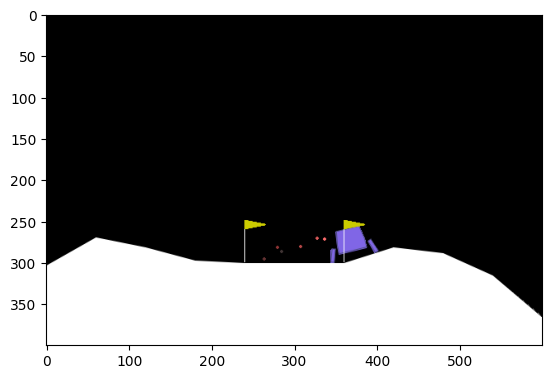

In [60]:
import matplotlib.pyplot as plt
from IPython import display
import torch
import numpy as np


env = gym.make("LunarLander-v2", render_mode="rgb_array")
state, _ = env.reset()

img = plt.imshow(env.render())  

racum = 0

for _ in range(10000): 
    state = torch.FloatTensor(state).unsqueeze(0).to(device) 
    with torch.no_grad():
        q_values = main_nn(state) 
    action = q_values.max(1)[1].item()  

    next_state, reward, done, info, _ = env.step(action)
    racum += reward
    img.set_data(env.render())  
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state = next_state  

    if done:
        print("reward", racum)
        break  

env.close()
